https://github.com/jxx123/fireTS

# 1. ARIMA
[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) (**A**uto**R**egressive **I**ntegrated **M**oving **A**verage) is an statistical model aiming to demonstrate the auto-correlations in time series data. The term *auto* means we are examining the relationship between our series with historical versions of itself (lagged series).

## 1.1. ARIMA model

### ARIMA functions
In a nutshell, ARIMA is a combination of 3 separated processes:

- Integration, $\text{I}(d)$. In this process, the model keeps differencing a time series until it's stationary. The parameter $d$ is the order of differencing and is determined using ADF test. The term *integration* shares the same meaning as summing, which implies the reverse of differencing.

- Auto-Regressive, $\text{AR}(p)$. In this process, we perform a linear regression model where input variables are lagged versions of our data. The parameter $p$ indicates the maximum lag degree and is determined using PACF of a stationary series: when a coefficient suddenly drops to 0, then the corresponding lag is a possible value for $p$. The $\text{AR}(p)$ function is:

$$\begin{align}
\hat{y}_t
&= c+\phi_1y_{t-1}+\phi_2y_{t-2}+\dots+\phi_py_{t-p} \\
&= c+(\phi_1B+\phi_2B^2+\dots+\phi_pB^p)y_t \\
\end{align}$$

- Moving Average model, $\text{MA}(q)$. It models our time series as a linear combination of past error (denoted $\epsilon$, where $\epsilon_{t-k}=y_{t-k}-\phi_1 y_{t-k-1}$). The parameter $q$ indicates the maximum lag degree and is determined using ACF chart of a stationary series, in a similar decision-making process as for $p$. The $\text{MA}(q)$ functions is:

$$\begin{align}
\hat{y}_t
&= c+\theta_1\epsilon_{t-1}+\theta_2\epsilon_{t-2}+\dots+\theta_q\epsilon_{t-q} \\
&= c+(\theta_1B+\theta_2B^2+\dots+\theta_qB^q)\epsilon_t \\
\end{align}$$

The entire model $\text{ARIMA}(p,d,q)$ is written as below:

$$(1-B)^d\hat{y}_t=c+(\phi_1B+\phi_2B^2+\dots+\phi_pB^p)(1-B)^dy_t+(\theta_1B+\theta_2B^2+\dots+\theta_qB^q)\epsilon_t$$

### Procedure
- *Estimation*. ARIMA estimates its parameters $c,\phi_1,\phi_2,\dots,\phi_p,\theta_1,\theta_2,\dots,\theta_q$ either by minimizing sum of squared errors ([OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares)) or by maximizing likelihood ([MLE](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)). Both methods return the same result.

- *Point forecasting*. It's obvious, by looking at ARIMA function, that each observation at time $t$ is modeled using previous step $t-1,t-2,\dots$. This prediction is written $\hat{y}_{t|t-1}$. As we have known all values up to time $T$, the forecasting is done in a *recursive* behaviour: $\hat{y}_{T+1|T},\hat{y}_{T+2|T+1},\dots,\hat{y}_{T+h|T+h-1}$.

- *Prediction interval*. Being a regression model, ARIMA assumes that fitted residuals are normally distributed. Thus the confidence interval is given by $z_{\alpha/2}\sigma_h$ where $\alpha$ is significance level and $\sigma_h$ is the forecast standard deviation, it is proportional to the variance of residuals and $h$. But also note that when the above assumption is not hold, then prediction interval may be incorrect.

### Hyperparameters tuning
Hyperparameters tuning (also known as model selection) for ARIMA is the process of choosing appropriate values for $p$, $q$ and $d$. While the selection of $d$ is very straightforward, we would want to put more focus on tuning $p$ and $q$. As described earlier, viable values for $p$ and $q$ can be obtained by looking at PACF and ACF charts of the differenced series, respectively. However, this method usually returns a number of choices rather than guarantees a single optimal selection. Thus we treat it as a tool for limiting potential candidates, then perform greedy search. The objective of exhausted search in ARIMA is to minimize an *information criterion*, which has several options:
- [Akaike's Information Criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion):
$\text{AIC} = -2 \log(L) + 2(p+q+k+1)$
- [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion):
$\text{BIC} = \text{AIC} + [\log(T)-2](p+q+k+1)$
- AICc, a corrected version of AIC for small data, in which time series is usually the case. When $n\rightarrow\infty$, AICc converges to AIC.

All the above information criteria are constructed of the *loss* part and the *regularization* part. The regularization part prevents the model from adding too many explanatory variables and makes sure the model has a good forecasting power. It is recommended to use AICc in real-world tasks.

## 1.2. Extensions

### SARIMA
SARIMA (**S**easonal **ARIMA**) is an extended version of ARIMA so that it is capable of learning seasonal patterns. The new model is written as:

$$\text{ARIMA} (p,d,q) \times (P,D,Q)_m$$

where $m$ is sesonal period and $(P,Q,D)$ are seasonal hyperparameters. Since SARIMA is very complicated, writing the entire function down is not convenient; it's better going through each of its newly added components.
- $m$: the seasonal period. It is very easy to be pointed out after doing some analyses.
- $D$: the order of seasonal differencing. The process is to apply seasonal differencing first to *de-seasonality*, then apply non-seasonal differencing to *de-trend*, until our data is stationary. Basically, after performing both types of differencing, we end up working on the series $(1-B^m)^D(1-B)^dy_t$.
- $P$: the seasonal lag degree for auto-regressive model. For example, we are estimating monthly profit using profit of this month last year, this month 2 years ago,..., this month $P$ years ago. Viable values for $P$ are also determined using PACF, but this time we only look at seasonal lags.
- $Q$: the seasonal lag degree for moving average model. We can also select $Q$ by looking at seasonal lags in ACF.

### SARIMAX
SARIMAX (**SARIMA** with e**X**ogenous variables) adds other independent variables $\mathbf{x}_1,\mathbf{x}_2,\dots$ to the SARIMA function. This function, stand alone, is given by:

$$\hat{\mathbf{y}}=c+\beta_1\mathbf{x}_1+\beta_2\mathbf{x}_2+\dots$$

Exogenous variables should be predictable, for examples: holidays, so they can be used to forecast in the same time step. If we don't know their values in the future, we can only use them to study their effects on $\mathbf{y}$.

## 1.3. Implementation
We are going to implement the complete version of ARIMA via the class
<code style='font-size:13px'><a href='https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>SARIMAX</a></code>.

- <code style='font-size:13px; color:#BA2121'>order</code>: the non-seasonal orders in the form of a tuple $(p,d,q)$, defaults to *(1, 0, 0)*. $d$ must be an integer, while $p$ and $q$ can be an integer (using all lagged series up to that value) or a list (using only specific lags).
- <code style='font-size:13px; color:#BA2121'>seasonal_order</code>: the seasonal orders in the form of a tuple $(P,D,Q,m)$, defaults to *(0, 0, 0, 0)*. $D$ and $m$ must be an integer; $P$ and $Q$ can be either an integer or a list.

In [1]:
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR, SVAR, VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS

from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings; warnings.filterwarnings('ignore')

In [130]:
dfQuantity = pd.read_csv('data/purchase_quantity.csv')
dfQuantity = dfQuantity.assign(date=dfQuantity.date.astype('datetime64'))
s = dfQuantity.set_index('date').quantity
s.head()

date
2019-10-28    379.49
2019-10-29    669.51
2019-10-30    337.17
2019-10-31    603.74
2019-11-01    189.82
Name: quantity, dtype: float64

In [131]:
nTest = 30

cutEnd = dfQuantity.shape[0]
cutTest = cutEnd - nTest

xTest, yTest = s[:cutTest], s[cutTest:]

In [134]:
model = SARIMAX(xTest, order=(0,1,0), seasonal_order=(0,1,1,30), trend='t').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                             quantity   No. Observations:                  219
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 30)   Log Likelihood               -1362.931
Date:                              Tue, 07 Jun 2022   AIC                           2731.861
Time:                                      16:39:38   BIC                           2741.571
Sample:                                  10-28-2019   HQIC                          2735.795
                                       - 06-02-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0044      0.091      0.048      0.961      -0.173       0.182
ma.S.L30      -0.6024      0.092     -6.527      0.000      -0.783      -0.422
sigma2      1.094e+05   6473.300     16.899      0.000    9.67e+04    1.22e+05
===================================================================================
Ljung-Box (L1) (Q):                  25.09   Jarque-Bera (JB):               303.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
forecaster = model.get_forecast(nTest)
yTestPred = forecaster.predicted_mean.rename('forecast')
dfForecast = yTestPred.to_frame()
dfForecast['truth'] = yTest
listCi = [0.9, 0.95, 0.99]
for ci in listCi:
    strCi = int(ci*100)
    dfCi = forecaster.summary_frame(alpha=1-ci)
    dfCi = dfCi.iloc[:, -2:]
    dfForecast[[f'ci_{strCi}_lower', f'ci_{strCi}_upper']] = dfCi
dfForecast.tail()

,forecast,truth,ci_90_lower,ci_90_upper,ci_95_lower,ci_95_upper,ci_99_lower,ci_99_upper
2020-06-28,579.380992,0.00,-2195.270502,3354.032485,-2726.820185,3885.582168,-3765.703888,4924.465871
2020-06-29,523.334258,304.24,-2304.158566,3350.827082,-2845.831247,3892.499763,-3904.499777,4951.168292
2020-06-30,610.140558,661.91,-2269.224030,3489.505145,-2820.833966,4041.115082,-3898.924297,5119.205412
2020-07-01,636.740589,729.94,-2293.577684,3567.058863,-2854.948997,4128.430176,-3952.117382,5225.598561
2020-07-02,748.354686,608.80,-2232.046284,3728.755657,-2803.012114,4299.721486,-3918.932439,5415.641811


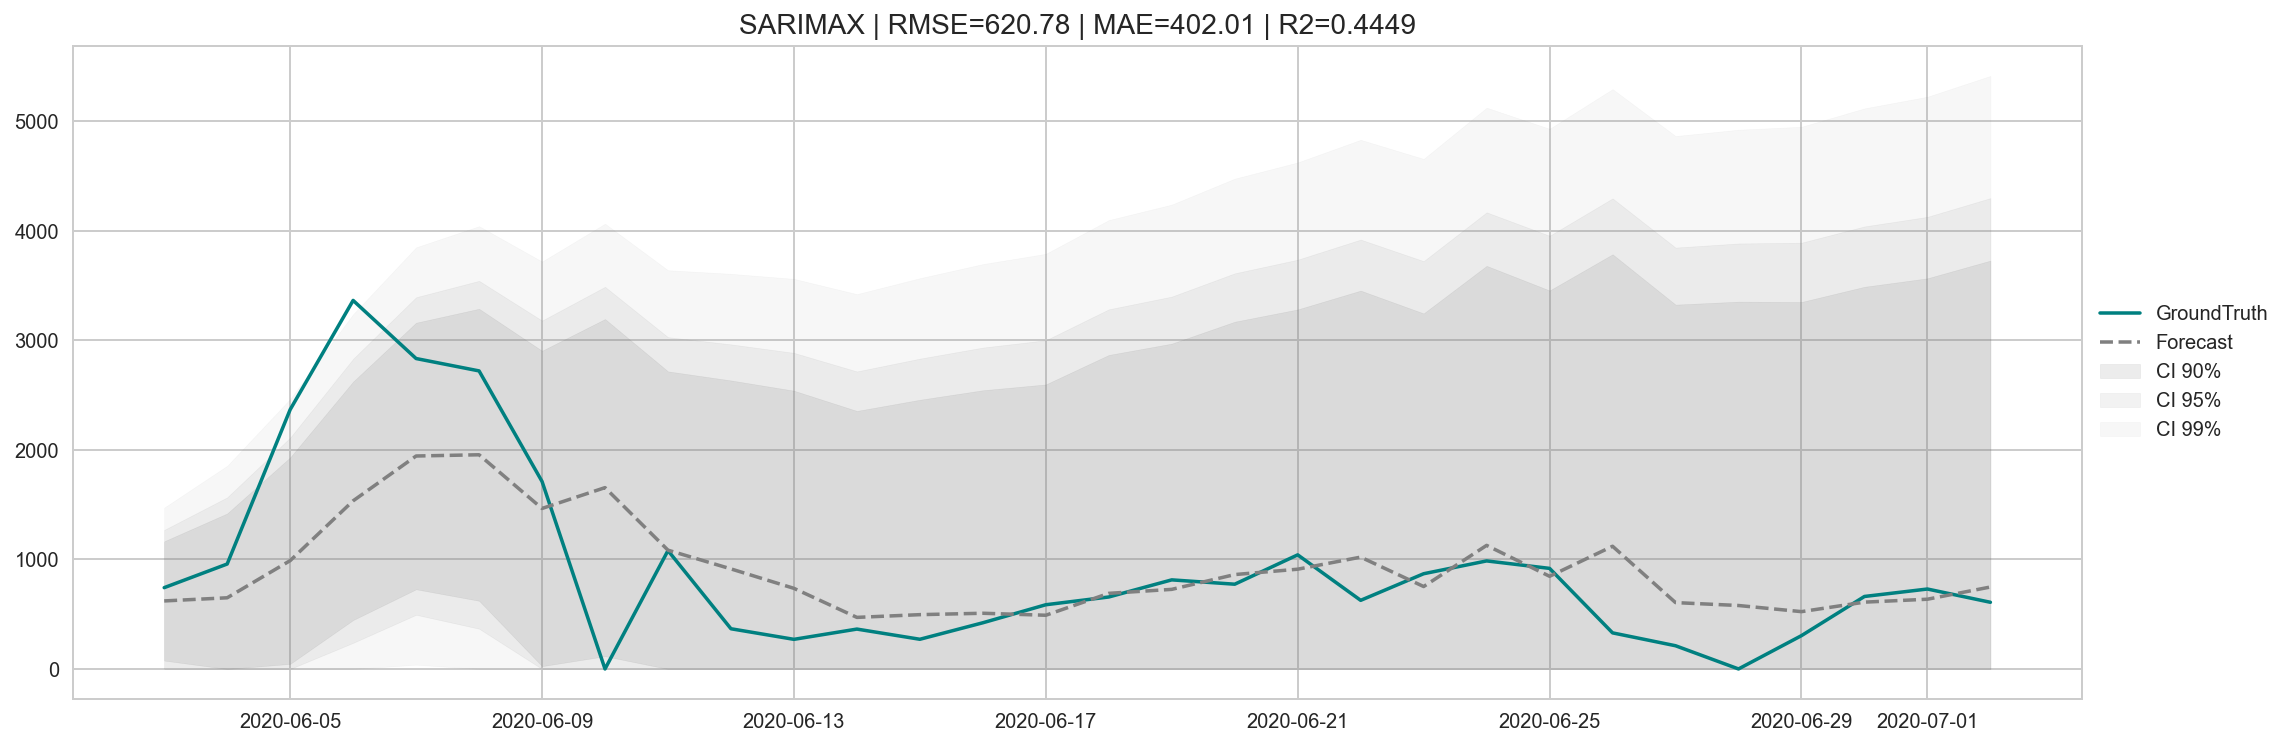

In [138]:
df = dfForecast.copy()
df = df.clip(lower=0)

rmse = MSE(yTest, yTestPred, squared=False)
mae = MAE(yTest, yTestPred)
r2 = R2(yTest, yTestPred)
title = f'SARIMAX | RMSE={rmse:.2f} | MAE={mae:.2f} | R2={r2:.4f}'

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df.truth, color='teal', label='GroundTruth')
ax.plot(df.forecast, '--', c='grey', label='Forecast')
for ci in listCi:
    alpha = 1 - ci + 0.05
    strCi = int(ci*100)
    lower, upper = df[f'ci_{strCi}_lower'], df[f'ci_{strCi}_upper']
    ax.fill_between(df.index, lower, upper, color='grey', alpha=alpha, label=f'CI {strCi}%')
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
ax.set_title(title, fontsize=14)
plt.show()

# 2. ETS
ETS (**E**rror, **T**rend and **S**easonality) is the [state-space](https://www.statsmodels.org/dev/statespace.html) form of Holt-Winters' method, which adds seasonality and trend to the simple *exponetial smoothing* model. The naive method assumes that only most recent observations are the most important ones.

## 2.1. Holt-Winters' method

### Level component
First, we go through the most basic foundation: exponential smoothing. A common sense is that most recent data should have a higher influence to the current value rather than further observations. Thus, we attach *exponentially decreasing weights* to observations, described as a *smoothing parameter*, $\alpha$ (for $0\leq\alpha\leq1$). The 1-step ahead forecast is given by the equation:

$$\hat{y}_{T+1|T}=\alpha y_T+\alpha(1-\alpha)y_{T-1}+\alpha(1-\alpha)^2y_{T-2}+\dots$$

The function is smartly designed, so that the sum of weights tends to reach $1$, especially when $T$ is large enough. This is because:

$$
\lim_{T\rightarrow\infty}\sum_{t=0}^{T-1}(1-\alpha)^t
=\lim_{T\rightarrow\infty}\frac{1-(1-\alpha)^T}{\alpha}
=\frac{1}{\alpha}
$$

The above function can be approximated using a recursion: $\hat{y}_{T+1|T}=\alpha y_{T}+(1-\alpha)\hat{y}_{T|T-1}$. Rewriting it gives us the very first component of ETS, the level $l_t$, represented as a weighted average between the last observation ($y_t$) and the last calculated level ($l_{t-1}$).

$$\begin{align*}
  \hat{y}_{t+h|t} & = l_{t}\\
  l_{t}        & = \alpha y_{t} + (1 - \alpha)l_{t-1}
\end{align*}$$

- $\hat{y}_{t+h|t}$ is a fitted value for $t=1,2,\dots,T-1$ and $h=1$
- $\hat{y}_{t+h|t}$ is a forecast for $t=T$ and $h=1,2,\dots$

The level component is parameterized by $\alpha$ and $l_0$ (the initial value to calculate $l_1$). Notice that the forecast function returns a *flat forecat*, as it does not depend on $h$.

### Trend component
If we think the level at time $t$ as some sort of *intercept*, then we need a *slope*. Let's denote it $b_t$ and model it using the last *instantaneous velocity* ($l_t-l_{t-1}$) and, of course, the last value of its own sequence ($b_{t-1}$):

$$b_t=\beta'(l_t-l_{t-1})+(1-\beta')b_{t-1}$$

Here, $\beta'\,(0\leq\beta'\leq1)$ is a smothing parameter. By plugging in the equation for $l_t$ and denoting $\beta=\alpha\beta'\,(0\leq\beta\leq\alpha)$, we can extend the simple exponential smoothing equation:

$$\begin{align*}
  \hat{y}_{t+h|t} &= l_t + hb_t \\
  l_t             &= \alpha y_{t} + (1-\alpha)(l_{t-1}+b_{t-1}) \\
  b_t             &= \beta(y_t-l_{t-1}) + (1-\beta)b_{t-1}
\end{align*}$$

Holt, the author of this method named it *trend*, but keep in mind that it is not the same *trend* as in component decomposition. An important conslusion can be drawn from the formulation is that the forecast function is now a linear function of $h$ rather than a constant. This function is less naive, but tends to overforecast in further horizons. This is the motivation for a damping parameter, $\phi\,(0\leq\phi\leq1)$, which has proven its success and popularity in forecasting tasks. The equation for damped trend is given by:

$$\begin{align*}
  \hat{y}_{t+h|t} &= l_t + (\phi+\phi^2+\dots+\phi^h)b_t \\
  l_t             &= \alpha y_{t} + (1-\alpha)(l_{t-1}+\phi b_{t-1}) \\
  b_t             &= \beta(y_t-l_{t-1}) + (1-\beta)\phi b_{t-1}
\end{align*}$$

If $\phi=1$ then there is no damping at all, while a lower value of $\phi$ indicates a very strong damping effect. In practice, $\phi$ should not be less than $0.8$. In addition to $\beta$ and $\phi$, trend component also has the initial value $b_0$ as a parameter.

### Seasonality component
The seasonal part ($s_t$) in ETS requires a pre-selected seasonal period ($m$), and the same number of seasonal initial values ($s_{-m+1},s_{-m+2},\dots,s_0$). For example, to model quarterly data ($m=4$), the intial values are $s_{-3},s_{-2},s_{-1},s_0$. The equation for seasonal component stand alone is expressed by the weighted average of the current seasonal term ($y_t-l_t$) and the last seasonal term ($s_{t-m}$) :

$$s_t=\gamma'(y_t-l_t)+(1-\gamma')s_{t-m}$$

$0\leq\gamma'\leq1$ is a smoothing parameter. If we substitute $l_t$ from the smoothing equation and $\gamma=(1-\alpha)\gamma'\,(0\leq\gamma\leq1-\alpha)$, we end up getting the complete ETS model. When expressing the equations, the damping factor is removed for simplification purposes.

$$\begin{align*}
  \hat{y}_{t+h|t} &= l_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  l_t &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(l_{t-1} + b_{t-1}) \\
  b_{t} &= \beta(y_t-l_{t-1}-s_{t-m})+(1-\beta)b_{t-1} \\
  s_t &= \gamma (y_{t}-l_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m}
\end{align*}$$

The term $s_{t+h-m(k+1)}\,(k=\lfloor(h-1)/m\rfloor)$ may look ugly, but it is just the seasonal term of the same index last observed period.

## 2.2. ETS model

### ETS function
[State space](https://www.statsmodels.org/dev/statespace.html) is an abstract representation of time series models, including both ARIMA and Holt-Winters. For Holt-Winters only, each of its components (or *states*) can be represented as an equation of *error*. This state space form has a better readability than Holt-Winters' function.

$$\begin{align*}
    y_t &= l_{t-1}+\phi b_{t-1}+s_{t-m}+\epsilon_t \\
    l_t &= l_{t-1}+\phi b_{t-1}+\alpha\epsilon_t \\
    b_t &= \phi b_{t-1}+\beta\epsilon_t \\
    s_t &= s_{t-m}+\gamma\epsilon_t
\end{align*}$$

Each component of error, trend and seasonality has two forms: additive and multiplicative. To distinguish between different combinations, we use the syntax: $\text{ETS}(\cdot\cdot\cdot)$, in which each dot stands for the form of the corresponding component: error, trend and seasonality. For example, $\text{ETS(A,Md,M)}$ stands for an ETS model with additive error, damped multiplicative trend and multiplicative seasonality.

### Procedure
- *Estimation*. Like ARIMA, ETS also estimates its parameters either by minimizing sum of squared error or maximizing the likelihood that error follows a normal distribution. ETS's parameters are coefficients (both smoothing and damping): $\alpha$, $\beta$, $\gamma$ and $\phi$ and initial values: $l_0$, $b_0$ and $s_0,s_{-1},\dots,s_{-m+1}$.

- *Point forecasting*. When forecasting future points using ETS equations ($t>T$), we only need to set $\epsilon_t=0$. For further forecasts ($h>1$), the same *recursion* fashion used in ARIMA is applied.

- *Prediction interval*. ETS also uses forecast variance to add confidence interval to point forecast. The formulas gets more and more complicated as we add more components and use multiplicative method, so they aren't going to be presented here.

### Hyperparameters tuning
Hyperparameters tuning for ETS is the process of choosing the appropriate form for each component. Like in ARIMA, we can minimize information criteria (AIC, AICc and BIC). But as there are only a few number of combinations ($2^4=16$), we'd better use Machine Learning's approach that exhausted searches for the best score (MAE, MSE or R2) on an observed validation set.

Some models, particularly $\text{ETS}(\text{A}\cdot\text{M})$ (additive error, multiplicative seasonal and any type of trend), can be excluded from our search and help reducing the computation time. These are potentially unstable models who suffer from division by very small numbers.

## 2.3. Implementation
We can implement Holt-Winters' model via class
<code style='font-size:13px'><a href='https://www.statsmodels.org/devel/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>ExponentialSmoothing</a></code>
or ETS model via class
<code style='font-size:13px'><a href='https://www.statsmodels.org/devel/generated/statsmodels.tsa.exponential_smoothing.ets.ETSModel.html'>ETSModel</a></code>. Both classes share the same hyperparameters, the later class sacrifies the capability of extracting model components (level, trend and season) in trade-off for generalization.

- <code style='font-size:13px; color:#BA2121'>error</code>: the type of error model, defaults to *add*. The other option is *mul*.
- <code style='font-size:13px; color:#BA2121'>trend</code>: the type of trend model, defaults to *None*. Other options are *add* and *mul*.
- <code style='font-size:13px; color:#BA2121'>damped_trend</code>: whether to use damping factor in the trend model, defaults to *False*. The other option is *True*.
- <code style='font-size:13px; color:#BA2121'>seasonal</code>: the type of seasonality model, defaults to *None*. Other options are *add* and *mul*.
- <code style='font-size:13px; color:#BA2121'>seasonal_periods</code>: the length of a season, defaults to *None*. Must be an integer if seasonal model is used.

In [103]:
import numpy as np
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS

from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

import warnings; warnings.filterwarnings('ignore')

In [104]:
dfQuantity = pd.read_csv('data/purchase_quantity.csv')
dfQuantity = dfQuantity.assign(date=dfQuantity.date.astype('datetime64'))
s = dfQuantity.set_index('date').quantity
s.head()

date
2019-10-28    379.49
2019-10-29    669.51
2019-10-30    337.17
2019-10-31    603.74
2019-11-01    189.82
Name: quantity, dtype: float64

In [140]:
nTest = 30

cutEnd = dfQuantity.shape[0]
cutTest = cutEnd - nTest

xTest, yTest = s[:cutTest], s[cutTest:]

In [153]:
model = ETS(xTest, trend='add', damped_trend=True, seasonal='add', seasonal_periods=30, freq='D').fit()
result = model.summary().tables

In [142]:
result[0]

Dep. Variable:,quantity,No. Observations:,219
Model:,ETS(AAdA),Log Likelihood,-1529.151
Date:,"Tue, 07 Jun 2022",AIC,3132.302
Time:,16:43:02,BIC,3257.698
Sample:,10-28-2019,HQIC,3182.946
,- 06-02-2020,Scale,67980.277
Covariance Type:,approx,,


In [143]:
result[2]

Ljung-Box (Q):,70.89,Jarque-Bera (JB):,196.46
Prob(Q):,0.00,Prob(JB):,0.00
Heteroskedasticity (H):,3.24,Skew:,-0.58
Prob(H) (two-sided):,0.00,Kurtosis:,7.49


In [147]:
forecaster = model.get_prediction(cutTest, cutEnd-1)
yTestPred = forecaster.predicted_mean.rename('forecast')
dfForecast = yTestPred.to_frame()
dfForecast['truth'] = yTest
listCi = [0.9, 0.95, 0.99]
for ci in listCi:
    strCi = int(ci*100)
    dfCi = forecaster.summary_frame(alpha=1-ci)
    dfCi = dfCi.iloc[:, -2:]
    dfForecast[[f'ci_{strCi}_lower', f'ci_{strCi}_upper']] = dfCi
dfForecast.tail()

,forecast,truth,ci_90_lower,ci_90_upper,ci_95_lower,ci_95_upper,ci_99_lower,ci_99_upper
2020-06-28,505.658104,0.00,-934.301371,1945.617578,-1210.159440,2221.475647,-1749.308387,2760.624594
2020-06-29,415.254539,304.24,-1050.717878,1881.226956,-1331.559337,2162.068415,-1880.448038,2710.957116
2020-06-30,467.350354,661.91,-1024.181410,1958.882118,-1309.919363,2244.620071,-1868.377982,2803.078690
2020-07-01,409.722661,729.94,-1106.937785,1926.383108,-1397.489727,2216.935050,-1965.357015,2784.802338
2020-07-02,510.193281,608.80,-1031.186243,2051.572805,-1326.473705,2346.860268,-1903.596300,2923.982862


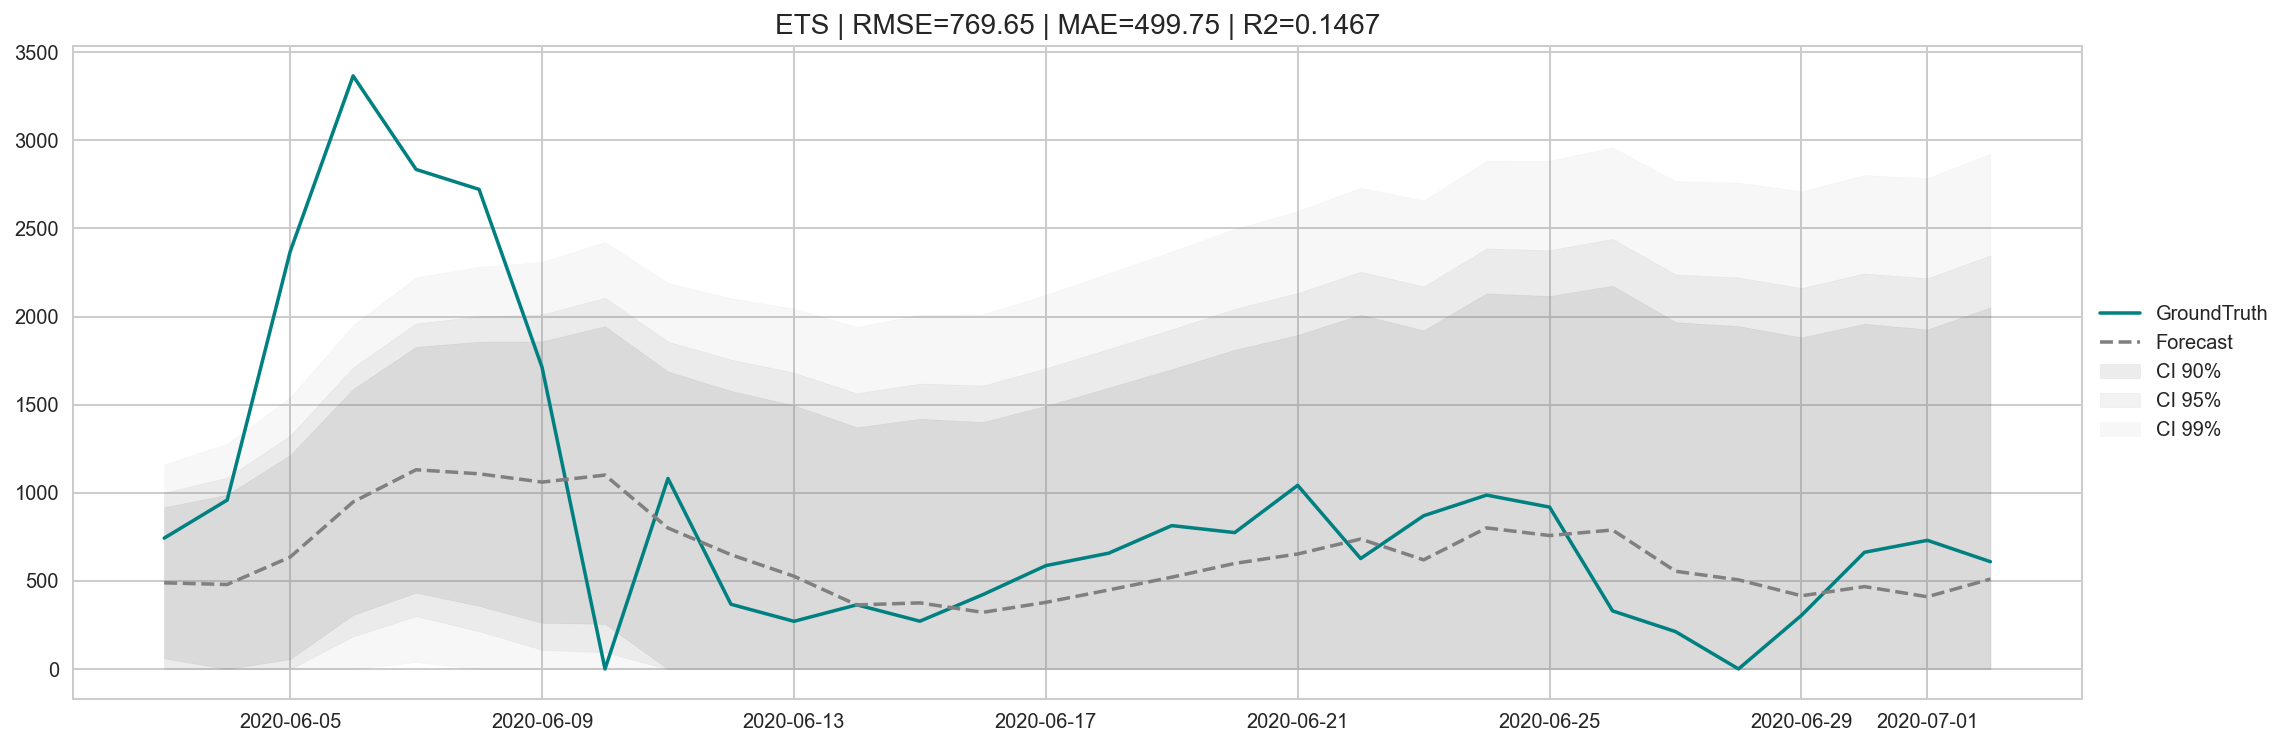

In [150]:
df = dfForecast.copy()
df = df.clip(lower=0)

rmse = MSE(yTest, yTestPred, squared=False)
mae = MAE(yTest, yTestPred)
r2 = R2(yTest, yTestPred)
title = f'ETS | RMSE={rmse:.2f} | MAE={mae:.2f} | R2={r2:.4f}'

fig, ax = plt.subplots(figsize=(18,6))
ax.plot(df.truth, color='teal', label='GroundTruth')
ax.plot(df.forecast, '--', c='grey', label='Forecast')
for ci in listCi:
    alpha = 1 - ci + 0.05
    strCi = int(ci*100)
    lower, upper = df[f'ci_{strCi}_lower'], df[f'ci_{strCi}_upper']
    ax.fill_between(df.index, lower, upper, color='grey', alpha=alpha, label=f'CI {strCi}%')
ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
ax.set_title(title, fontsize=14)
plt.show()

# 3. VAR
[VAR](https://en.wikipedia.org/wiki/Vector_autoregression) (**V**ector **A**uto**R**egression)

## 3.1. VAR Model

A VAR model is a generalisation of the univariate autoregression model for forcasting a vector of time series. In VAR model, all variables are treated symmetrically - all of them are *endogenous*. The structure of VAR is each variable is a linear function of past lags of itself and past lags of the other variables.

*Explaination:*

Example with 2 variables:
$$a_t = c_1 + \sum_{j=1}^{j=p} A_j a_{t-j} + \sum_{j=1}^{j=p} B_j b_{t-j} + e_{1,t} \\
  b_t = c_2 + \sum_{j=1}^{j=p} D_j a_{t-j} + \sum_{j=1}^{j=p} E_j b_{t-j} + e_{2,t}$$
  
- Two equations contains only its own lagged values and the lagged value of others variables - no current values of two variables on right-hand sides.
- Although the number of lagged values of each variable can be different, in most cases we use the same number of lagged terms in each equation.
- The model above is called $\mbox{VAR(p)}$ because of $p$ lagged values of each variable. 

*The general form of VAR: The function of VAR is actually the OLS method with stationary time series*:

$$y_t = c + A_1 y_{t-1} + A_2 y_{t-2}+\cdots +A_p y_{t-p}+e_{t}$$

$A_i$: Square matrix $m*m, i=1,2,\dots,p$\
$y_t$: $m$ stationary variables $y_{1t}, y_{2t},\dots, y_{mt}$\
$e_t$: vector of white noise

*The work flow:*

Step 1: Check the stationary of all time series. We have 2 possibilities:
- If all variables are stationary, we can estimated VAR model by OLS
- If all variables are I(1), make them stationary and move to step 2:

Step 2: Find the lag $p$ for model. Depend on metric $\mbox{AIC}$, $\mbox{FPE}$, $\mbox{SC}$ and $\mbox{HQIC}$ - The lag reach the largest numbers of minimum metrics will be the lag for model.

Step 3: Estimated the VAR model by OLS.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

plt.style.use(['seaborn', 'seaborn-whitegrid'])
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [46]:
dfCpi = pd.read_csv('data/cpi.csv')
dfCpi = dfCpi.astype({'month': 'datetime64'})
dfCpi = dfCpi.set_index('month')
dfCpi.head()

,ex_rate,money_supply,inf
month,,,
2009-01-01,16954,1.582872e+06,15.536579
2009-02-01,16953,1.722413e+06,6.701754
2009-03-01,16991,1.830077e+06,2.417558
2009-04-01,17941,1.914078e+06,4.602838
2009-05-01,18544,1.964660e+06,9.696635


In [47]:
for i in dfCpi.columns:
    test = adfuller(dfCpi[i])
    print(f'ADF of {i}: {test[0]}')
    print(f'p-value of {i}: {test[1]}')

ADF of ex_rate: -2.6047933525515283
p-value of ex_rate: 0.09201062038116359
ADF of money_supply: 3.857985254022738
p-value of money_supply: 1.0
ADF of inf: -1.554106971814962
p-value of inf: 0.5065960721917747


In [48]:
dfCpiDif = dfCPI.diff().dropna()

for i in dfCpiDif.columns:
    test = adfuller(dfCpiDif[i])
    print(f'ADF of {i}: {test[0]}')
    print(f'p-value of {i}: {test[1]}')

ADF of ex_rate: -6.723311823514879
p-value of ex_rate: 3.4392095149141533e-09
ADF of money_supply: -4.971584105329942
p-value of money_supply: 2.5253803145699296e-05
ADF of inf: -5.33587795514765
p-value of inf: 4.612428921750133e-06


In [49]:
var = VAR(dfCpiDif)
result = var.fit(maxlags=4, ic='aic', verbose=True)
result.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 1, FPE -> 4, HQIC -> 1>
Using 4 based on aic criterion


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Jul, 2021
Time:                     21:51:12
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    37.1056
Nobs:                     39.0000    HQIC:                   36.0390
Log likelihood:          -818.136    FPE:                2.67178e+15
AIC:                      35.4421    Det(Omega_mle):     1.12716e+15
--------------------------------------------------------------------
Results for equation ex_rate
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 171.053850       261.584879            0.654           0.513
L1.ex_rate             -0.126433         0.163305           -0.774           0.439
L1.money_supply        -0.000224         0.000543 

In [50]:
lags = result.k_ar

inf_pred = result.forecast(dfCpiDif[-lags:].values, steps=15)[:,2:3]
inf_pred = dfCpiDif['inf'].iloc[-1] + inf_pred.cumsum()
inf_pred

array([3.23590418, 3.29835561, 3.04879665, 3.49792176, 3.63751891,
       3.59901505, 3.78114786, 3.67908554, 3.62580333, 3.81903495,
       3.86660551, 3.88287442, 3.93823976, 3.89078186, 3.8963528 ])

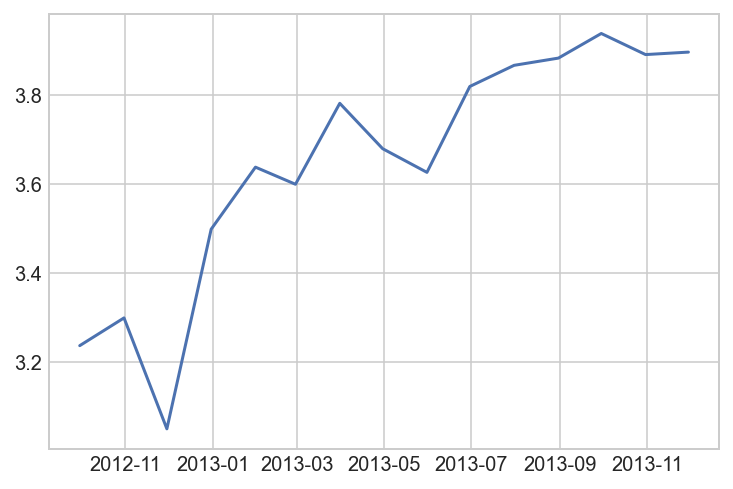

In [51]:
date = pd.date_range(start='2012-09-01', periods=15, freq='M')
dfPred = pd.DataFrame(inf_pred, index=date, columns=['inf'])

plt.plot(dfPred)
plt.show()

# References
- [Ebook] [Forecasting: Principles and Practice](https://otexts.com/fpp3/)
- [Ebook] [Forecasting and Analytics with Adam](https://www.openforecast.org/adam/)
- [Ebook] [STAT 510: Applied Time Series Analysis](https://online.stat.psu.edu/stat510/)

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*